<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch6-TD_Learning/WindyGridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
%matplotlib inline

## Windy Grid

This is the solution to Exercise-6.5 in Page-130 of the book ["Reinforcement Learning" by Barto, Sutton](http://incompleteideas.net/sutton/book/the-book.html).

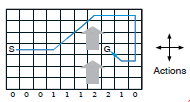

The summary of the problem is as follows:
1. Given the grid above, we need to find an optimal path from the start 'S' to the goal 'G' using the SARSA algorithm.
2. The grid also has a wind blowing from the bottom to the top. The speed of the wind serves to push the path in its direction by the intensity shown at the bottom of the grid above.
3. The first part of the problem focusses on finding a path using only horizontal & vertical moves as allowed actions.
4. The second part of the problem allows diagonal moves as part of the actions set.
5. The third part of the problem allows no moves in addition to the King's moves in Step-4 above.

In [2]:
grid_rows = 7
grid_cols = 10
start = [3,0]
goal  = [3,7]
hv_actions = [[-1,0],[0,1],[1,0],[0,-1]]

###Code

In [3]:
def getWind(pos):
  if pos[1] < 3 or pos[1] > 8:
    return [0,0]
  elif pos[1] in [6,7]:
    return [-2,0]
  return [-1,0]

def step(pos,act):
  wind = getWind(pos)
  next_pos = [min(grid_rows-1,max(0,pos[0]+act[0]+wind[0])),min(grid_cols-1,max(0,pos[1]+act[1]+wind[1]))]
  reward = -1
  return next_pos,reward

def target_policy(Q,pos,actions,epsilon):
  nA = len(actions)
  action_prob = epsilon/float(nA)*np.ones((nA,))
  maxQ = np.max(Q[pos[0],pos[1],:])
  idx = np.where(Q[pos[0],pos[1],:] == maxQ)[0]
  action_prob[idx] += (1-epsilon)/float(len(idx))
  return np.random.choice(range(nA),p=action_prob)

def play_back(Q,actions):
  pos = start
  traj = []
  while pos[0] != goal[0] or pos[1] != goal[1]:
    act_idx = target_policy(Q,pos,actions,0.0)
    next_pos,_ = step(pos,actions[act_idx])
    traj += [pos+[act_idx]]
    pos = next_pos
  return traj

def init_Q(actions):
  Q = np.zeros((grid_rows,grid_cols,len(actions)))
  for i in [0,grid_rows-1]:
    for j in range(grid_cols):
      for ia,a in enumerate(actions):
        if i+a[0] not in range(grid_rows) or j+a[1] not in range(grid_cols):
          Q[i,j,ia] = -np.inf
  for j in [0,grid_cols-1]:
    for i in range(grid_rows):
      for ia,a in enumerate(actions):
        if i+a[0] not in range(grid_rows) or j+a[1] not in range(grid_cols):
          Q[i,j,ia] = -np.inf
  return Q

def SARSA(num_episodes,actions,alpha,gamma,epsilon):
  nA = len(actions)
  Q = np.zeros((grid_rows,grid_cols,nA))
  stats = []
  for episode in range(num_episodes):#tqdm(range(num_episodes)):
    pos = start
    act_idx = target_policy(Q,pos,actions,epsilon)
    steps = 0
    rewards = 0
    while pos[0] != goal[0] or pos[1] != goal[1]:
      next_pos,reward = step(pos,actions[act_idx])
      rewards += reward
      next_act_idx = target_policy(Q,next_pos,actions,epsilon)
      Q[pos[0],pos[1],act_idx] += alpha*(reward + gamma*Q[next_pos[0],next_pos[1],next_act_idx] - Q[pos[0],pos[1],act_idx])
      pos = next_pos
      act_idx = next_act_idx
      steps += 1
    if len(stats) > 1:
      stats += [[episode+1,steps,stats[-1][-1]+steps]]
    else:
      stats += [[episode+1,steps,steps]]
  return Q,np.array(stats)

def plot_grid(ax,traj):
  # create discrete colormap
  cmap = colors.ListedColormap(['white','red','blue','green'])
  bounds = [0,0.1,3]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  map = np.zeros((grid_rows,grid_cols))
  map[start[0],start[1]] = 1
  map[goal[0],goal[1]] = 3
  for i,t in enumerate(traj):
    if i == 0:
      continue
    map[t[0],t[1]] = 2
  ax.imshow(map, cmap=cmap)#, norm=norm)
  ### draw gridlines
  # ax = plt.gca();
  ax.set_xticks(np.arange(-0.5, grid_cols+0.5, 1));
  ax.set_yticks(np.arange(-0.5, grid_rows+0.5, 1));
  ax.set_xticklabels(np.arange(-0.5, grid_cols+0.5, 1));
  ax.set_yticklabels(np.arange(-0.5, grid_rows+0.5, 1));
  ax.grid(color='k', linestyle='-', linewidth=1)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

## TD On-Policy Control with SARSA

In [4]:
num_runs = 50
num_episodes = 1000
alpha = 0.5
gamma = 1
epsilon = 0.1
# np.random.seed(0)
Q_avg = np.zeros((grid_rows,grid_cols,len(hv_actions)))
stats_avg = np.zeros((num_episodes,3))
for i in tqdm(range(num_runs)):
  Q,stats = SARSA(num_episodes,hv_actions,alpha,gamma,epsilon)
  Q_avg += Q/float(num_runs)
  stats_avg[:,1:] += stats[:,1:]/float(num_runs)
stats_avg[:,0] = stats[:,0]

100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


In [5]:
act_code = ['U','R','D','L']
print('Optimal Actions')
for i in range(grid_rows):
  print_str = ''
  for j in range(grid_cols):
    pos = [i,j]
    act_idx = target_policy(Q_avg,pos,hv_actions,0.0)
    print_str += act_code[act_idx] + ' , '
  print(print_str)

Optimal Actions
R , R , R , R , R , R , R , R , R , D , 
R , R , R , R , R , R , R , R , R , D , 
R , R , R , R , R , R , R , R , R , D , 
R , R , R , R , R , R , R , L , R , D , 
R , R , R , R , R , R , D , D , L , L , 
R , R , R , R , R , U , U , D , L , L , 
R , R , R , R , L , D , D , R , U , L , 


Trajectory Length: 15
[[3, 0, 1], [3, 1, 1], [3, 2, 1], [3, 3, 1], [1, 4, 1], [1, 5, 1], [0, 6, 1], [0, 7, 1], [0, 8, 1], [0, 9, 2], [0, 9, 2], [2, 9, 2], [3, 9, 2], [4, 9, 3], [4, 8, 3]]


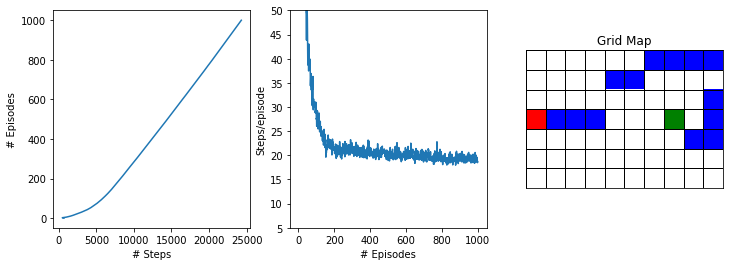

In [19]:
traj = play_back(Q_avg,hv_actions)
print('Trajectory Length:', len(traj))
print(traj)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(stats_avg[:,2],stats_avg[:,0])
ax[0].set_xlabel('# Steps')
ax[0].set_ylabel('# Episodes')
ax[1].plot(stats_avg[:,0],stats_avg[:,1])
ax[1].set_ylabel('Steps/episode')
ax[1].set_xlabel('# Episodes')
ax[1].set_ylim([5,50])
plot_grid(ax[2],traj)
ax[2].set_title('Grid Map');

## Kings Moves

In [7]:
kings_moves = hv_actions + [[-1,-1],[-1,1],[1,-1],[1,1]]
# np.random.seed(0)
Q_kings = np.zeros((grid_rows,grid_cols,len(kings_moves)))
stats_kings = np.zeros((num_episodes,3))
for i in tqdm(range(num_runs)):
  Q,stats = SARSA(num_episodes,kings_moves,alpha,gamma,epsilon)
  Q_kings += Q/float(num_runs)
  stats_kings[:,1:] += stats[:,1:]/float(num_runs)
stats_kings[:,0] = stats[:,0]

100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


In [8]:
act_code = ['U','R','D','L','UL','UR','DL','DR']
print('Optimal Actions')
for i in range(grid_rows):
  print_str = ''
  for j in range(grid_cols):
    pos = [i,j]
    act_idx = target_policy(Q_kings,pos,kings_moves,0.0)
    print_str += act_code[act_idx]
    if len(act_code[act_idx]) == 1:
       print_str += '  , '
    else:
      print_str += ' , '
  print(print_str)

Optimal Actions
DR , UL , D  , UL , UR , DR , DR , DR , UR , D  , 
DR , DR , D  , DL , DR , R  , UR , DR , DR , D  , 
DR , DR , D  , DL , DR , DR , DR , DR , DR , DL , 
DR , DR , DR , DL , DR , DR , DR , R  , DL , DL , 
DR , DR , DR , DR , DR , DR , DR , D  , L  , DL , 
DR , DR , DR , DR , DR , DR , R  , DR , UL , DL , 
R  , DR , DR , DR , DR , DR , UR , U  , DL , L  , 


Trajectory: 7
[[3, 0, 7], [4, 1, 7], [5, 2, 7], [6, 3, 7], [6, 4, 7], [6, 5, 7], [6, 6, 5]]


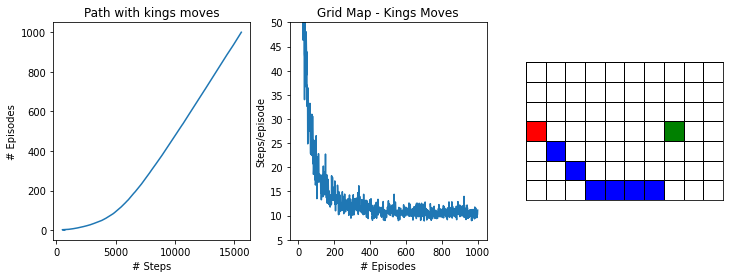

In [9]:
traj_kings = play_back(Q_kings,kings_moves)
print('Trajectory:',len(traj_kings))
print(traj_kings)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(stats_kings[:,2],stats_kings[:,0])
ax[0].set_xlabel('# Steps')
ax[0].set_ylabel('# Episodes')
ax[0].set_title('Path with kings moves')
ax[1].plot(stats_kings[:,0],stats_kings[:,1])
ax[1].set_ylabel('Steps/episode')
ax[1].set_xlabel('# Episodes')
ax[1].set_ylim([5,50])
plot_grid(ax[2],traj_kings)
ax[1].set_title('Grid Map - Kings Moves');

## Kings Moves with Stationary Option

In [10]:
kings_wStationary = kings_moves + [[0,0]]
Q_stationary = np.zeros((grid_rows,grid_cols,len(kings_wStationary)))
stats_stationary = np.zeros((num_episodes,3))
for i in tqdm(range(num_runs)):
  Q,stats = SARSA(num_episodes,kings_wStationary,alpha,gamma,epsilon)
  Q_stationary += Q/float(num_runs)
  stats_stationary[:,1:] += stats[:,1:]/float(num_runs)
stats_stationary[:,0] = stats[:,0]

100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


In [11]:
act_code = ['U','R','D','L','UL','UR','DL','DR','S']
print('Optimal Actions')
for i in range(grid_rows):
  print_str = ''
  for j in range(grid_cols):
    pos = [i,j]
    act_idx = target_policy(Q_stationary,pos,kings_wStationary,0.0)
    print_str += act_code[act_idx]
    if len(act_code[act_idx]) == 1:
       print_str += '  , '
    else:
      print_str += ' , '
  print(print_str)

Optimal Actions
DR , DR , D  , L  , UR , R  , DR , UR , DR , D  , 
DR , DR , D  , DR , DR , DR , R  , DR , DR , DR , 
DR , DR , D  , DL , DR , DR , DR , DR , DR , DL , 
DR , DR , DR , DL , DR , DR , DR , D  , DL , DL , 
DR , DR , DR , DR , DR , DR , DR , D  , L  , DL , 
DR , DR , DR , DR , DR , DR , R  , S  , UL , DL , 
R  , R  , R  , DR , DR , DR , UR , UR , DL , L  , 


Trajectory Length: 7
[[3, 0, 7], [4, 1, 7], [5, 2, 7], [6, 3, 7], [6, 4, 7], [6, 5, 7], [6, 6, 5]]


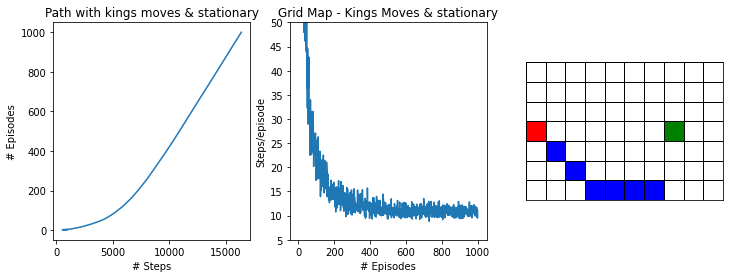

In [12]:
traj_stationary = play_back(Q_stationary,kings_wStationary)
print('Trajectory Length:', len(traj_stationary))
print(traj_stationary)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(stats_stationary[:,2],stats_stationary[:,0])
ax[0].set_xlabel('# Steps')
ax[0].set_ylabel('# Episodes')
ax[0].set_title('Path with kings moves & stationary')
ax[1].plot(stats_stationary[:,0],stats_stationary[:,1])
ax[1].set_ylabel('Steps/episode')
ax[1].set_xlabel('# Episodes')
ax[1].set_ylim([5,50])
ax[0].set_title('Path with kings moves & stationary')
plot_grid(ax[2],traj_stationary)
ax[1].set_title('Grid Map - Kings Moves & stationary');

## Stochastic Wind

In [13]:
def getWind(pos):
  ## Stochastic
  w = np.random.choice([-1,0,1])
  if pos[1] < 3 or pos[1] > 8:
    return [0+w,0]
  elif pos[1] in [6,7]:
    return [-2+w,0]
  return [-1+w,0]

In [14]:
Q_stochastic = np.zeros((grid_rows,grid_cols,len(hv_actions)))
stats_stochastic = np.zeros((num_episodes,3))
for i in tqdm(range(num_runs)):
  Q,stats = SARSA(num_episodes,hv_actions,alpha,gamma,epsilon)
  Q_stochastic += Q/float(num_runs)
  stats_stochastic[:,1:] += stats[:,1:]/float(num_runs)
stats_stochastic[:,0] = stats[:,0]

100%|██████████| 50/50 [04:40<00:00,  5.60s/it]


In [15]:
act_code = ['U','R','D','L']
print('Optimal Actions')
for i in range(grid_rows):
  print_str = ''
  for j in range(grid_cols):
    pos = [i,j]
    act_idx = target_policy(Q_stochastic,pos,hv_actions,0.0)
    print_str += act_code[act_idx] + ' , '
  print(print_str)

Optimal Actions
R , R , R , R , R , R , R , R , R , D , 
R , R , R , R , R , R , R , R , R , D , 
R , R , R , R , R , R , R , R , R , D , 
R , R , R , R , R , R , R , D , R , D , 
R , R , R , R , R , R , R , D , L , D , 
R , R , R , R , R , R , R , D , L , L , 
R , R , R , R , R , R , R , D , L , L , 


Trajectory Length: 19
[[3, 0, 1], [4, 1, 1], [4, 2, 1], [3, 3, 1], [3, 4, 1], [1, 5, 1], [0, 6, 1], [0, 7, 1], [0, 8, 1], [0, 9, 2], [2, 9, 2], [3, 9, 2], [4, 9, 2], [4, 9, 2], [4, 9, 2], [6, 9, 3], [6, 8, 3], [5, 7, 2], [4, 7, 2]]


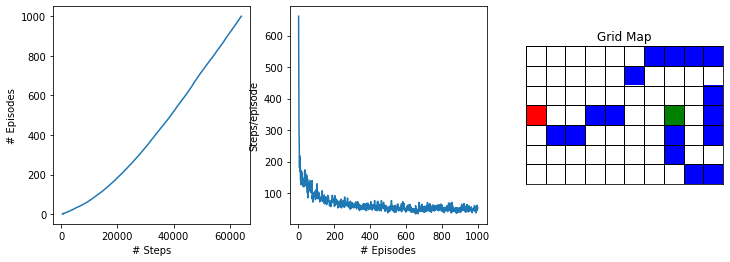

In [18]:
traj = play_back(Q_stochastic,hv_actions)
print('Trajectory Length:', len(traj))
print(traj)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(stats_stochastic[:,2],stats_stochastic[:,0])
ax[0].set_xlabel('# Steps')
ax[0].set_ylabel('# Episodes')
ax[1].plot(stats_stochastic[:,0],stats_stochastic[:,1])
ax[1].set_ylabel('Steps/episode')
ax[1].set_xlabel('# Episodes')
# ax[1].set_ylim([5,50])
plot_grid(ax[2],traj)
ax[2].set_title('Grid Map');